In [9]:
## 1. Imports from libraries

In [1]:
import pandas as pd #for data manipulation and analysis. 
import numpy as np #for scientific computing
import datetime as dt
import os # for interacting with the operating system
import os.path
from pathlib import Path
import glob # to define techniques to match specified patterns
import cv2 #to solve computer vision problems
import matplotlib.pyplot as plt
import seaborn as sns #a data visualization library 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

In [2]:
## 2. Organizing Training and Testing Dataframes

In [3]:
# Selecting Dataset Folder Paths
f_dir_ = Path('C:/Users/nigeetawadhwani/Desktop/EyeDetector/femaleeyes')
m_dir_ = Path('C:/Users/nigeetawadhwani/Desktop/EyeDetector/maleeyes')
femaleeyes_filepaths = list(f_dir_.glob(r'**/*.jpg'))
maleeyes_filepaths = list(m_dir_.glob(r'**/*.jpg'))

# Mapping the labels
fm_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], femaleeyes_filepaths))
ml_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], maleeyes_filepaths))

# Paths & labels femalee eyes
fm_filepaths = pd.Series(femaleeyes_filepaths, name = 'File').astype(str)
fm_labels = pd.Series(fm_labels, name='Label')

# Paths & labels malee eyes
ml_filepaths = pd.Series(maleeyes_filepaths, name = 'File').astype(str)
ml_labels = pd.Series(ml_labels, name='Label')

# Concatenating...
femaleeyes_df = pd.concat([fm_filepaths, fm_labels], axis=1)
maleeyes_df = pd.concat([ml_filepaths, ml_labels], axis=1)


#meraging both
df = pd.concat([femaleeyes_df, maleeyes_df])

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

In [4]:
## 3. Observing the images

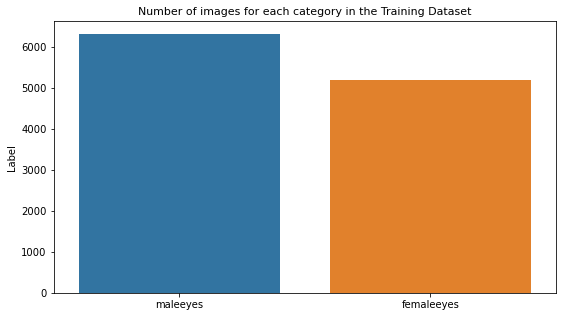

In [5]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

In [6]:
plt.style.use("dark_background")

Text(0.5, 1.0, 'maleeyes')

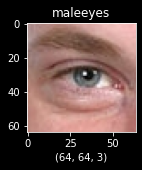

In [7]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'femaleeyes')

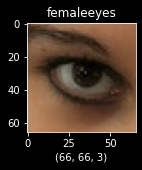

In [8]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][11])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][11])

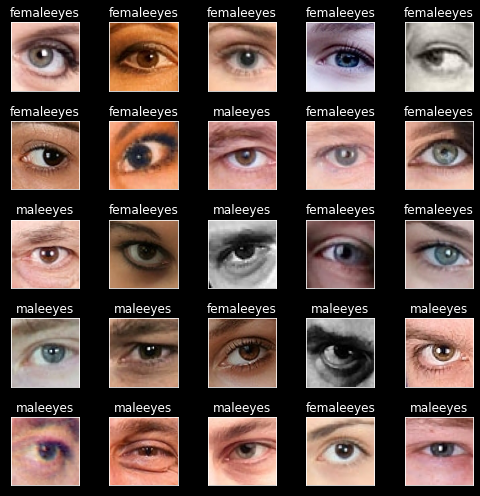

In [9]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

In [10]:
## 3. Dividing into training and testing sets
#Now we need to convert our data into training and testing sets. We will use 80% of the images as our training data and test our model on the remaining 20% with Scikit-learn's train_test_split function.

In [11]:
trainset_df, testset_df = train_test_split(df, train_size = 0.80, random_state = 135)

display(trainset_df.head())

testset_df.head()

,File,Label
9677,C:\Users\nigeetawadhwani\Desktop\EyeDetector\m...,maleeyes
7494,C:\Users\nigeetawadhwani\Desktop\EyeDetector\f...,femaleeyes
8614,C:\Users\nigeetawadhwani\Desktop\EyeDetector\f...,femaleeyes
10414,C:\Users\nigeetawadhwani\Desktop\EyeDetector\m...,maleeyes
6797,C:\Users\nigeetawadhwani\Desktop\EyeDetector\m...,maleeyes


,File,Label
4646,C:\Users\nigeetawadhwani\Desktop\EyeDetector\f...,femaleeyes
2074,C:\Users\nigeetawadhwani\Desktop\EyeDetector\m...,maleeyes
8991,C:\Users\nigeetawadhwani\Desktop\EyeDetector\m...,maleeyes
8581,C:\Users\nigeetawadhwani\Desktop\EyeDetector\f...,femaleeyes
10468,C:\Users\nigeetawadhwani\Desktop\EyeDetector\m...,maleeyes


In [12]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [13]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with malee eyes: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with malee eyes: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 9220
Number of images with malee eyes: 5086
Number of images with femalee eyes: 4134

Test Dataset:
Number of images: 2305
Number of images with malee eyes: 1237
Number of images with femalee eyes: 1068



In [14]:
# 4. Generating batches of images
#In this part we will generate batches of images
#for the test database we will just normalize the data
#using [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class)

#Parameters of ``ImageDataGenerator``:

#    rescale - Transform image size (normalization of data)
 #   shear_range - Random geometric transformations
  #  zoom_range - Images that will be zoomed
   # rotation_range - Degree of image rotation
 #   width_shift_range - Image Width Change Range
  #  height_shift_range - Image height change range
   # horizontal_flip - Rotate images horizontally
   # vertical_flip - Rotate images vertically
   # validation_split - Images that have been reserved for validation (0-1)

In [15]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
            +                        rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
## 5. Directory of training, validation and test images

#Here we make the division of the image bases for training, validation and testing of the model, for that 
#we use the [flow_from_dataframe](https://keras.io/api/preprocessing/image/#flowfromdataframe-method)

#Parameters of ``flow_from_directory``:

#    dataframe - Dataframe containing the images directory
 #   x_col - Column name containing the images directory
  #  y_col - Name of the column containing what we want to predict
 #   target_size - size of the images (remembering that it must be the same size as the input layer)
  #  color_mode - RGB color standard
   # class_mode - binary class mode (cat/dog)
   # batch_size - batch size (32)
    #shuffle - Shuffle the data
    #seed - optional random seed for the shuffle
    #subset - Subset of data being training and validation (only used if using validation_split in ImageDataGenerator)

In [17]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 8298 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 922 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 2305 validated image filenames belonging to 2 classes.
Data generators are ready!


In [18]:
print("Training: ")
print(training_set.class_indices)
print(training_set.image_shape)
print("---" * 8)
print("Validation: ")
print(validation_set.class_indices)
print(validation_set.image_shape)
print("---" * 8)
print("Test: ")
print(test_set.class_indices)
print(test_set.image_shape)

Training: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Validation: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Test: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)


In [19]:
#Use of callbacks to monitor models and see if metrics will improve, otherwise training is stopped.

#EarlyStopping`` parameters:

 #   monitor - Metrics that will be monitored
  #  patience - Number of times without improvement in the model, after these times the training is stopped
   # restore_best_weights - Restores best weights if training is interrupted

In [20]:
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 20, restore_best_weights = True)]

In [21]:
## 6. Construction of the first model (ConvNet)

In [22]:
#step 1 convolutional layer
CNN = Sequential()
# filters =32, kernal size is 3 * 3
CNN.add(Conv2D(32, (3, 3), input_shape = (75, 75, 3), activation = 'relu'))
CNN.add(BatchNormalization())

In [23]:
#step 2 max pooling
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [24]:
#step 3: hidden layers 

In [25]:
CNN.add(Conv2D(32, (3, 3), activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [26]:
CNN.add(Conv2D(64, (3, 3), activation = 'relu'))
CNN.add(SpatialDropout2D(0.2))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [27]:
###### Step 4 - Flattening
    
    # Transforming the matrix to a vector to enter the Artificial Neural Network layer

In [28]:
CNN.add(Flatten())

In [29]:
###### Step 5 - Dense Neural Networks

In [30]:
# Input layer
CNN.add(Dense(units = 128, activation = 'relu'))
CNN.add(Dropout(0.2))
# Output layer (binary classification)
CNN.add(Dense(units = 1, activation = 'sigmoid'))

print(CNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 15, 15, 64)        0

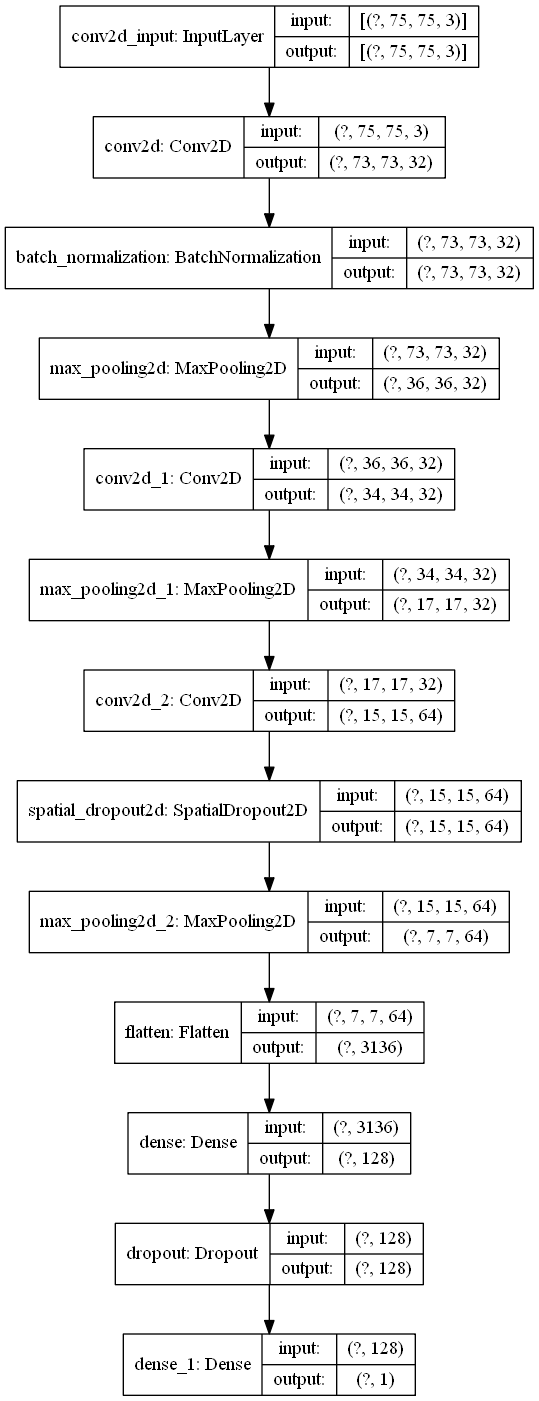

In [39]:
plot_model(CNN, to_file='CNN_model.png', show_layer_names = True , show_shapes = True)

In [32]:
###### Step 6 - Model compilation and training
# Compile
CNN.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time...
start = dt.datetime.now()

# Train
CNN_model = CNN.fit(training_set, epochs = 200, validation_data = validation_set, callbacks = cb)

# End of counting time...
end = dt.datetime.now()
time_CNN = end - start
print ('\nTraining and validation time is: ', time_CNN)

Epoch 1/200
260/260 [==============================] - 227s 872ms/step - loss: 0.6084 - accuracy: 0.6729 - val_loss: 0.6292 - val_accuracy: 0.7039
Epoch 2/200
260/260 [==============================] - 73s 279ms/step - loss: 0.5168 - accuracy: 0.7421 - val_loss: 0.4854 - val_accuracy: 0.7950
Epoch 3/200
260/260 [==============================] - 72s 278ms/step - loss: 0.4466 - accuracy: 0.7946 - val_loss: 0.3853 - val_accuracy: 0.8536
Epoch 4/200
260/260 [==============================] - 74s 286ms/step - loss: 0.3995 - accuracy: 0.8156 - val_loss: 0.3366 - val_accuracy: 0.8666
Epoch 5/200
260/260 [==============================] - 73s 281ms/step - loss: 0.3747 - accuracy: 0.8350 - val_loss: 0.3220 - val_accuracy: 0.8742
Epoch 6/200
260/260 [==============================] - 74s 284ms/step - loss: 0.3483 - accuracy: 0.8496 - val_loss: 0.4374 - val_accuracy: 0.7939
Epoch 7/200
260/260 [==============================] - 73s 281ms/step - loss: 0.3426 - accuracy: 0.8489 - val_loss: 0.2748 

Epoch 57/200
260/260 [==============================] - 53s 203ms/step - loss: 0.1971 - accuracy: 0.9214 - val_loss: 0.1834 - val_accuracy: 0.9317
Epoch 58/200
260/260 [==============================] - 53s 204ms/step - loss: 0.1940 - accuracy: 0.9226 - val_loss: 0.1988 - val_accuracy: 0.9284
Epoch 59/200
260/260 [==============================] - 52s 200ms/step - loss: 0.2004 - accuracy: 0.9193 - val_loss: 0.1676 - val_accuracy: 0.9393
Epoch 60/200
260/260 [==============================] - 52s 200ms/step - loss: 0.1971 - accuracy: 0.9215 - val_loss: 0.1925 - val_accuracy: 0.9382
Epoch 61/200
260/260 [==============================] - 52s 200ms/step - loss: 0.1935 - accuracy: 0.9237 - val_loss: 0.2262 - val_accuracy: 0.9024
Epoch 62/200
260/260 [==============================] - 53s 205ms/step - loss: 0.1885 - accuracy: 0.9212 - val_loss: 0.1810 - val_accuracy: 0.9262
Epoch 63/200
260/260 [==============================] - 52s 201ms/step - loss: 0.1878 - accuracy: 0.9254 - val_loss: 0

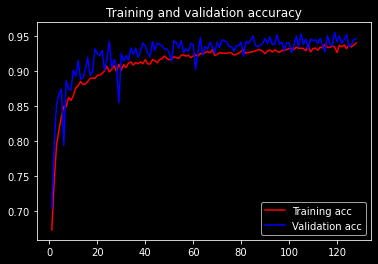

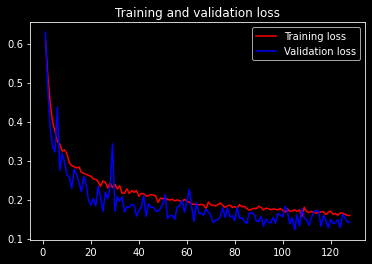

In [33]:
acc = CNN_model.history['accuracy']
val_acc = CNN_model.history['val_accuracy']
loss = CNN_model.history['loss']
val_loss = CNN_model.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [34]:
score_CNN = CNN.evaluate(test_set)
print("Test Loss:", score_CNN[0])
print("Test Accuracy:", score_CNN[1])

73/73 [==============================] - 67s 923ms/step - loss: 0.2343 - accuracy: 0.9085
Test Loss: 0.2343195527791977
Test Accuracy: 0.9084598422050476


In [35]:
y_pred_CNN = CNN.predict(test_set)
y_pred_CNN = np.round(y_pred_CNN)

recall_CNN = recall_score(y_test, y_pred_CNN)
precision_CNN = precision_score(y_test, y_pred_CNN)
f1_CNN = f1_score(y_test, y_pred_CNN)
roc_CNN = roc_auc_score(y_test, y_pred_CNN)

In [36]:
print(classification_report(y_test, y_pred_CNN))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1068
           1       0.86      0.98      0.92      1237

    accuracy                           0.91      2305
   macro avg       0.92      0.90      0.91      2305
weighted avg       0.92      0.91      0.91      2305



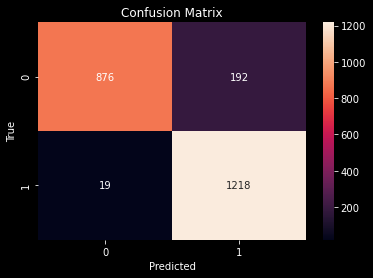

In [37]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_CNN),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [38]:
# Save the model
modelFileName = 'gender-with-eye-classifier.h5'
CNN.save(modelFileName)
print('model saved as', modelFileName)

model saved as gender-with-eye-classifier.h5


![alt_text](observation_1.png "observation")

![alt_text](observation_2.png)

![alt_text](observation_3.png)

![alt_text](observation_4.png)